In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [ ]:
# Fungsi untuk mempersiapkan data
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Unduh dan muat data dari Yahoo Finance
symbol = '^JKLQ45'  # Simbol untuk indeks LQ-45
start_date = '1997-02-25'
end_date = '2024-01-31'
data = yf.download(symbol, start=start_date, end=end_date)['Close'].values.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


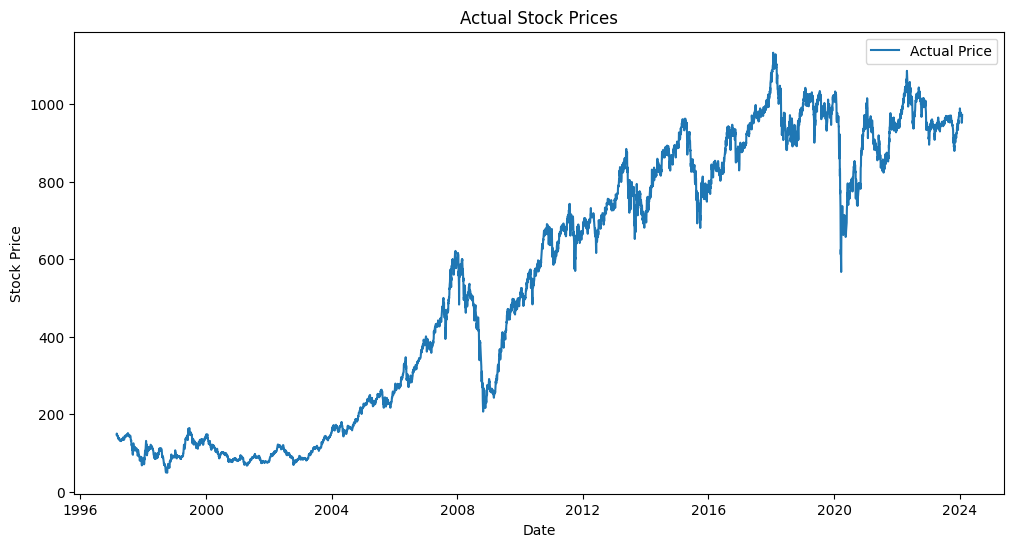

In [ ]:
# Ambil tanggal untuk plot
dates = yf.download(symbol, start=start_date, end=end_date).index

# Plotting DataFrame secara full sebelum pelatihan
plt.figure(figsize=(12, 6))
plt.plot(dates, scaler.inverse_transform(scaled_data), label='Actual Price')
plt.title('Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Tentukan parameter
time_steps = 60  # Panjang sekuens input untuk model
train_size = int(len(scaled_data) * 0.7)  # Ukuran set pelatihan
validation_size = int(train_size * 0.1)  # Ukuran set validasi
test_size = len(scaled_data) - train_size

In [ ]:
# Persiapkan data train, validation, dan test
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size+validation_size]
test_data = scaled_data[train_size+validation_size:]

X_train, y_train = prepare_data(train_data, time_steps)
X_val, y_val = prepare_data(val_data, time_steps)
X_test, y_test = prepare_data(test_data, time_steps)

In [ ]:
def fruit_fly_algorithm(num_flies, num_iterations, X_train, y_train, X_val, y_val, scaler):
    def create_model(params):
        units, lr, dropout, activation, batch_size, num_layers, epochs = params
        model = Sequential([Input(shape=(X_train.shape[1], X_train.shape[2]))])

        # Add GRU layers dynamically based on num_layers
        for _ in range(num_layers):
            model.add(GRU(units=int(units), activation=activation, dropout=dropout, return_sequences=True if _ < num_layers - 1 else False))

        model.add(Dense(units=1))  # Output layer
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model, batch_size, epochs

    best_rmse = float('inf')
    best_params = None
    results = []

    for iteration in range(num_iterations):
        for fly in range(num_flies):
            # Updated random parameter ranges
            units = np.random.randint(16, 256)  # GRU units
            lr = 10 ** np.random.uniform(-6, -1)  # Learning rate
            dropout = 10 ** np.random.uniform(-5, -3) # Dropout rate
            activation = np.random.choice(['tanh', 'relu', 'selu', 'sigmoid'])  # Activation function
            batch_size = np.random.choice([8, 16, 32, 64, 128, 256])  # Batch size
            num_layers = np.random.randint(1, 6)  # Number of GRU layers (1 to 5)
            epochs = np.random.randint(10, 100)  # Epochs (10 to 100)

            params = [units, lr, dropout, activation, batch_size, num_layers, epochs]
            model, batch_size, epochs = create_model(params)

            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

            # Calculate RMSE
            predictions = model.predict(X_val)

            # Handle NaN values
            if np.isnan(predictions).any() or np.isnan(y_val).any():
                print(f"Iteration {iteration + 1}, Fly {fly + 1}: NaN detected in predictions or targets. Skipping this fly.")
                continue

            rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val), scaler.inverse_transform(predictions)))

            # Store results
            results.append({'params': params, 'rmse': rmse})
            print(f"Iteration {iteration + 1}, Fly {fly + 1}: {params}, RMSE={rmse}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params

    print("Optimization complete!")
    print(f"Best RMSE: {best_rmse} with parameters: {best_params}")

    sorted_results = sorted(results, key=lambda x: x['rmse'])
    print("\nTop 3 results:")
    for i, res in enumerate(sorted_results[:3], 1):
        print(f"Rank {i}: RMSE={res['rmse']}, Params={res['params']}")

    return best_params, sorted_results

# Preprocessing step: Handle NaN values in the datasets
X_train = np.nan_to_num(X_train)  # Replace NaN in X_train with 0
y_train = np.nan_to_num(y_train)  # Replace NaN in y_train with 0
X_val = np.nan_to_num(X_val)      # Replace NaN in X_val with 0
y_val = np.nan_to_num(y_val)      # Replace NaN in y_val with 0

# Call the function
num_flies = 10
num_iterations = 5
best_params, sorted_results = fruit_fly_algorithm(num_flies, num_iterations, X_train, y_train, X_val, y_val, scaler)

# Print Top 3 results
print("\n=== Top 3 Best Results ===")
for i, res in enumerate(sorted_results[:3], 1):
    params = res['params']
    print(f"Rank {i}:")
    print(f"  RMSE: {res['rmse']}")
    print(f"  Units: {params[0]}")
    print(f"  Learning Rate: {params[1]}")
    print(f"  Dropout: {params[2]}")
    print(f"  Activation: {params[3]}")
    print(f"  Batch Size: {params[4]}")
    print(f"  Number of Layers: {params[5]}")
    print(f"  Number of Epochs: {params[6]}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
Iteration 1, Fly 1: [114, 0.09671869442377128, 0.0001095077849785144, 'selu', 16, 4, 37], RMSE=1934134409697053.5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
Iteration 1, Fly 2: [223, 1.4543059313639495e-06, 0.00011448610506681837, 'selu', 64, 4, 93], RMSE=26.84677991592239
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
Iteration 1, Fly 3: [62, 0.0005999149475366552, 0.00021920665909446575, 'relu', 128, 5, 36], RMSE=59.19526842478627
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step
Iteration 1, Fly 4: [153, 3.762349160884814e-05, 0.0005610120590064395, 'relu', 8, 5, 18], RMSE=15.978182756814826
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Iteration 1, Fly 5: [210, 2.0789533461661012e-05, 0.00018955540324880603, 'tanh', 32, 5, 48], RMSE=16.412499877320712
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Iteration 1, Fly 6: NaN detected in predictions or targets. Skipping this fly.
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Iteration 1, Fly 7: NaN detected in predictions or target

In [ ]:
# Model GRU standar tanpa optimizer Adam
model_gru_standard = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(units=50, activation='tanh'),
    Dense(units=1)
])
model_gru_standard.compile(loss='mean_squared_error')
model_gru_standard.summary()
print(model_gru_standard.optimizer)

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_151 (GRU)                        │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model GRU dengan optimizer Adam
model_gru_adam = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(units=50, activation='tanh'),
    Dense(units=1)
])
model_gru_adam.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
model_gru_adam.summary()
print(model_gru_adam.optimizer)

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_152 (GRU)                        │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Extract the best parameters including the number of layers
best_units, best_lr, best_dropout, best_activation, best_batch_size, best_num_layers, best_epochs = best_params

# Build the model based on the optimal number of layers
model_gru_foa = Sequential([Input(shape=(X_train.shape[1], X_train.shape[2]))])

# Add GRU layers dynamically based on the best number of layers
for _ in range(best_num_layers):
    model_gru_foa.add(GRU(units=int(best_units), activation=best_activation, dropout=best_dropout,
                          return_sequences=True if _ < best_num_layers - 1 else False))

model_gru_foa.add(Dense(units=1))  # Output layer

# Use the best learning rate for the optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)

# Compile the model
model_gru_foa.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model summary
model_gru_foa.summary()

# Print the optimizer details
print(model_gru_foa.optimizer)

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_153 (GRU)                        │ (None, 60, 215)             │         140,610 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_154 (GRU)                        │ (None, 60, 215)             │         278,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_155 (GRU)                        │ (None, 215)                 │         278,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │             216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 698,106 (2.66 MB)

 Trainable params: 698,106 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Latih model GRU standar tanpa optimizer yang ditentukan secara eksplisit dengan data pelatihan dan validasi
history_standard = model_gru_standard.fit(X_train, y_train, epochs=50, batch_size=32,
                                          validation_data=(X_val, y_val))

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0295 - val_loss: 3.4495e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.4787e-04 - val_loss: 1.3496e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2057e-04 - val_loss: 4.7683e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0142e-04 - val_loss: 5.5541e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8263e-04 - val_loss: 4.9281e-04
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6473e-04 - val_loss: 1.5504e-04
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2111e-04 - val_loss: 2.6064e-04
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9889e-04 - val_loss: 1.0123e-04
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0126e-04 - val_loss: 1.0261e-04
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8085e-04 - val_loss: 3.3937e-04
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.

In [ ]:
# Latih model GRU dengan optimizer Adam dengan data pelatihan dan validasi
history_adam = model_gru_adam.fit(X_train, y_train, epochs=50, batch_size=32,
                                  validation_data=(X_val, y_val))

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0325 - val_loss: 1.1503e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0249e-04 - val_loss: 1.0201e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8564e-05 - val_loss: 8.9439e-05
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6461e-05 - val_loss: 1.1764e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3319e-05 - val_loss: 9.2470e-05
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1560e-05 - val_loss: 9.8314e-05
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9689e-05 - val_loss: 7.2317e-05
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0451e-05 - val_loss: 7.2437e-05
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7404e-05 - val_loss: 7.0600e-05
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7591e-05 - val_loss: 6.8593e-05
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.

In [ ]:
# Latih model GRU dengan parameter terbaik dari FOA
history_foa = model_gru_foa.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size,
                                validation_data=(X_val, y_val))

Epoch 1/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0325 - val_loss: 0.0014
Epoch 2/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0010 - val_loss: 3.8162e-04
Epoch 3/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 6.4704e-04 - val_loss: 1.3349e-04
Epoch 4/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 4.9183e-04 - val_loss: 7.1847e-05
Epoch 5/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 3.9607e-04 - val_loss: 8.0967e-04
Epoch 6/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 3.5844e-04 - val_loss: 5.1032e-04
Epoch 7/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 3.4041e-04 - val_loss: 9.3248e-04
Epoch 8/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 2.9477e-04 - val_loss: 0.0020
Epoch 9/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 2.5254e-04 - val_loss: 2.0679e-04
Epoch 10/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 2.5297e-04 - val_loss: 8.9102e-05
Epoch 11/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step 

In [ ]:
# Lakukan prediksi
predictions_gru_standard = model_gru_standard.predict(X_test)
predictions_gru_adam = model_gru_adam.predict(X_test)
predictions_gru_foa = model_gru_foa.predict(X_test)

predictions_gru_standard = scaler.inverse_transform(predictions_gru_standard)
predictions_gru_adam = scaler.inverse_transform(predictions_gru_adam)
predictions_gru_foa = scaler.inverse_transform(predictions_gru_foa)
y_test = scaler.inverse_transform(y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


In [ ]:
# Hitung RMSE
rmse_standard = np.sqrt(mean_squared_error(y_test, predictions_gru_standard))
rmse_adam = np.sqrt(mean_squared_error(y_test, predictions_gru_adam))
rmse_foa = np.sqrt(mean_squared_error(y_test, predictions_gru_foa))

print("RMSE GRU Standar:", rmse_standard)
print("RMSE GRU Adam:", rmse_adam)
print("RMSE GRU FOA:", rmse_foa)

RMSE GRU Standar: 15.133551212335485
RMSE GRU Adam: 12.600892977064003
RMSE GRU FOA: 27.512402615825682


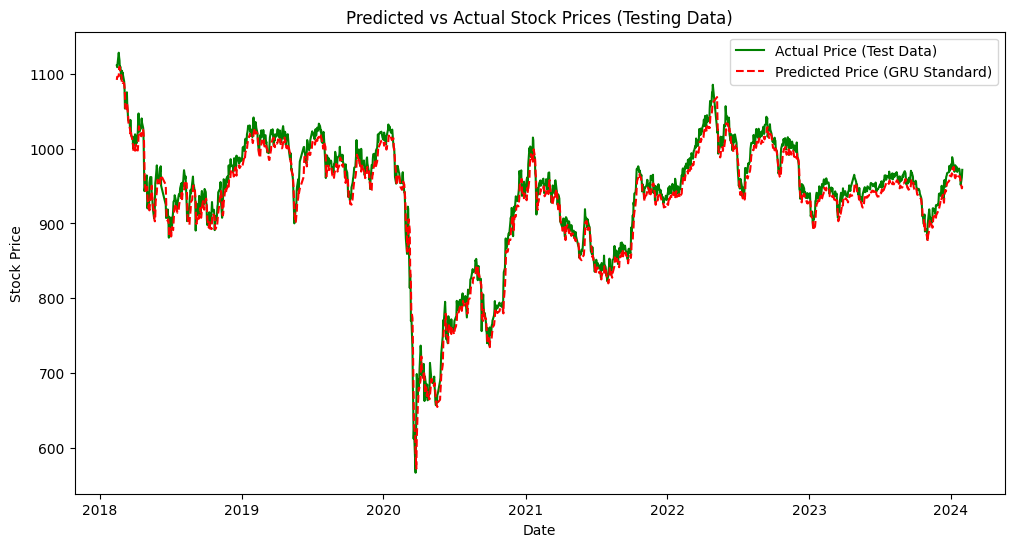

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dates[train_size+validation_size+time_steps:], y_test, label='Actual Price (Test Data)', color='green')
plt.plot(dates[train_size+validation_size+time_steps:], predictions_gru_standard, label='Predicted Price (GRU Standard)', linestyle='--', color='red')
plt.title('Predicted vs Actual Stock Prices (Testing Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

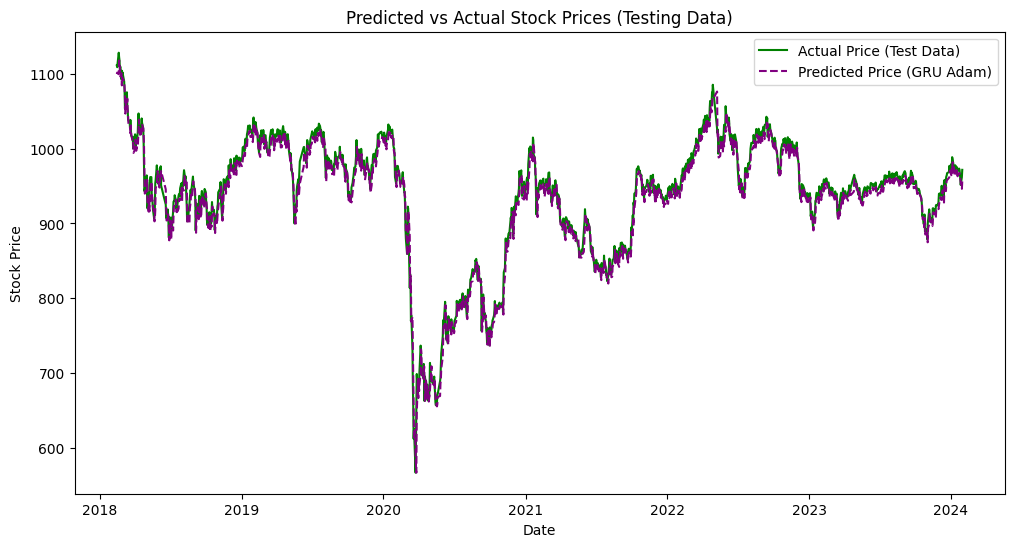

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dates[train_size+validation_size+time_steps:], y_test, label='Actual Price (Test Data)', color='green')
plt.plot(dates[train_size+validation_size+time_steps:], predictions_gru_adam, label='Predicted Price (GRU Adam)', linestyle='--', color='purple')
plt.title('Predicted vs Actual Stock Prices (Testing Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

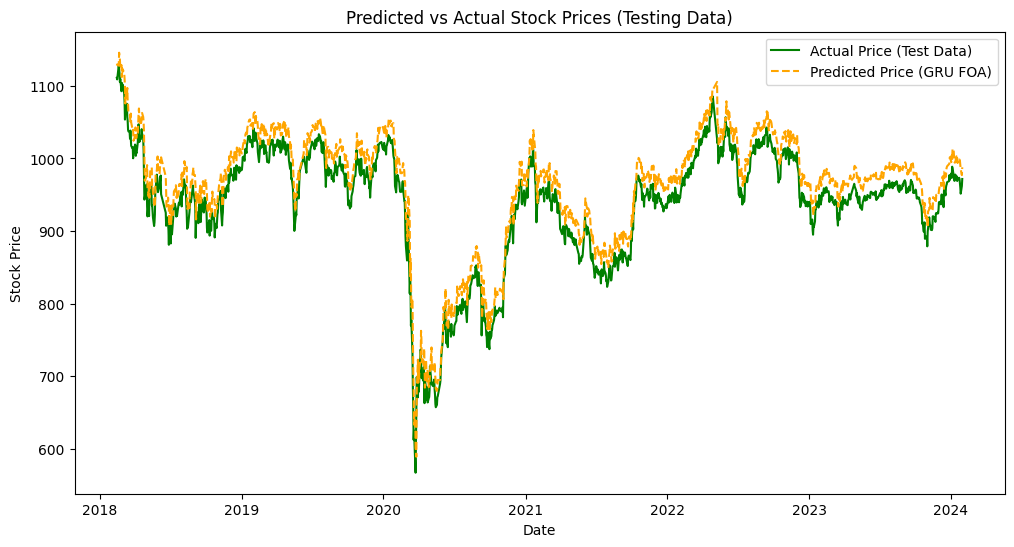

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dates[train_size+validation_size+time_steps:], y_test, label='Actual Price (Test Data)', color='green')
plt.plot(dates[train_size+validation_size+time_steps:], predictions_gru_foa, label='Predicted Price (GRU FOA)', linestyle='--', color='orange')
plt.title('Predicted vs Actual Stock Prices (Testing Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()